In [1]:
from ecnet.datasets import load_ysi, load_lhv

smiles_ysi, ysi = load_ysi()
smiles_lhv, lhv = load_lhv()

data_ysi = []
data_lhv = []
smiles = []

for idx_ysi, smi_ysi in enumerate(smiles_ysi):
    for idx, smi in enumerate(smiles_lhv):
        if smi_ysi == smi:
            data_ysi.append(ysi[idx_ysi])
            data_lhv.append(lhv[idx])
            smiles.append(smi_ysi)
            break

print(len(data_ysi), len(data_lhv), len(smiles))

139 139 139


In [2]:
from sklearn.preprocessing import StandardScaler

scaler_ysi = StandardScaler()
scaler_lhv = StandardScaler()
scaler_ysi.fit(data_ysi)
scaler_lhv.fit(data_lhv)
data_ysi = scaler_ysi.transform(data_ysi)
data_lhv = scaler_lhv.transform(data_lhv)

print(min(data_ysi), max(data_ysi))
print(min(data_lhv), max(data_lhv))

[-0.65429383] [5.2530424]
[-2.3695902] [1.30371506]


In [3]:
from sklearn.model_selection import train_test_split

smiles_train, smiles_test, ysi_train, ysi_test, lhv_train, lhv_test = train_test_split(smiles, data_ysi, data_lhv, test_size=0.25, random_state=0)

print(len(smiles_train), len(smiles_test))

104 35


In [4]:
################
### YSI ONLY ###
################

from ecnet.datasets import QSPRDataset

ds_train = QSPRDataset(smiles_train, ysi_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

In [5]:
from sklearn.decomposition import PCA
import torch

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([104, 104]) torch.Size([35, 104])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/3723054795.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/3723054795.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 101.70275594186091 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.08689435494496771 | Valid loss: 0.17367373406887054
Epoch: 50 | Train loss: 0.0060049176378094635 | Valid loss: 0.00569937052205205
Epoch: 75 | Train loss: 0.004395623348882773 | Valid loss: 0.005680803209543228
Epoch: 100 | Train loss: 0.0008835102924132261 | Valid loss: 0.0009366168524138629
Epoch: 125 | Train loss: 0.007988330624673677 | Valid loss: 0.012191529385745525
Epoch: 150 | Train loss: 0.06322057368368775 | Valid loss: 0.14949703216552734
Epoch: 175 | Train loss: 0.009750054299703164 | Valid loss: 0.013307238928973675


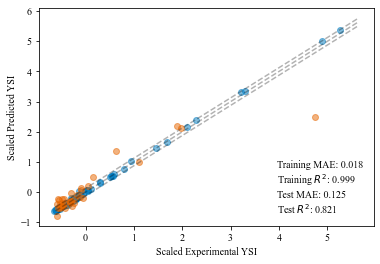

In [6]:
from ecnet import ECNet
from sklearn.metrics import median_absolute_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

model_ysi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_ysi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_ysi(ds_train.desc_vals).detach().numpy()
pred_test = model_ysi(ds_test.desc_vals).detach().numpy()

mae_train = median_absolute_error(ysi_train, pred_train)
mae_test = median_absolute_error(ysi_test, pred_test)

r2_train = r2_score(ysi_train, pred_train)
r2_test = r2_score(ysi_test, pred_test)

min_val = min(min(pred_train), min(ysi_train)) - 0.05 * min(min(pred_train), min(ysi_train))
max_val = max(max(pred_train), max(ysi_train)) + 0.05 * max(max(pred_train), max(ysi_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental YSI')
plt.ylabel('Scaled Predicted YSI')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--', alpha=0.3)
plt.scatter(ysi_train, pred_train, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(ysi_test, pred_test, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train, r2_train, mae_test, r2_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()


In [7]:
################
### LHV ONLY ###
################

ds_train = QSPRDataset(smiles_train, lhv_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, lhv_test, backend='alvadesc')

In [8]:
pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([104, 104]) torch.Size([35, 104])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/2641696615.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/2641696615.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 144.67028476880944 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.021819960029012916 | Valid loss: 0.026327351108193398
Epoch: 50 | Train loss: 0.004548941101150021 | Valid loss: 0.0031441550236195326
Epoch: 75 | Train loss: 0.007068921879365825 | Valid loss: 0.003698463086038828
Epoch: 100 | Train loss: 0.0012544809935101564 | Valid loss: 0.0008674340206198394
Epoch: 125 | Train loss: 0.0002555259519452364 | Valid loss: 0.0002737628819886595
Epoch: 150 | Train loss: 0.0004159378109709022 | Valid loss: 0.00040581118082627654
Epoch: 175 | Train loss: 0.00015764945229697648 | Valid loss: 0.00016413738194387406
Epoch: 200 | Train loss: 0.0003729734280436853 | Valid loss: 0.0005766889080405235
Epoch: 225 | Train loss: 0.0025326769184861064 | Valid loss: 0.0019257607636973262
Epoch: 250 | Train loss: 0.0034533445866764996 | Valid loss: 0.006745644845068455


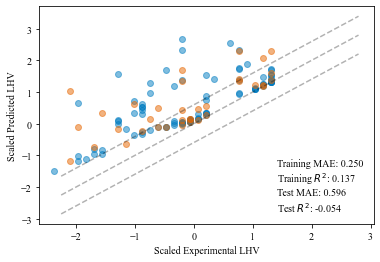

In [9]:
model_lhv = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_lhv.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_lhv(ds_train.desc_vals).detach().numpy()
pred_test = model_lhv(ds_test.desc_vals).detach().numpy()

mae_train = median_absolute_error(lhv_train, pred_train)
mae_test = median_absolute_error(lhv_test, pred_test)

r2_train = r2_score(lhv_train, pred_train)
r2_test = r2_score(lhv_test, pred_test)

min_val = min(min(pred_train), min(lhv_train)) - 0.05 * min(min(pred_train), min(lhv_train))
max_val = max(max(pred_train), max(lhv_train)) + 0.05 * max(max(pred_train), max(lhv_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental LHV')
plt.ylabel('Scaled Predicted LHV')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--', alpha=0.3)
plt.scatter(lhv_train, pred_train, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(lhv_test, pred_test, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train, r2_train, mae_test, r2_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

In [10]:
###################
### YSI and LHV ###
###################

import numpy as np

targets_train = np.concatenate((np.array(ysi_train), np.array(lhv_train)), axis=1)
targets_test = np.concatenate((np.array(ysi_test), np.array(lhv_test)), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)
print(ds_train.target_vals.shape, ds_test.target_vals.shape)

torch.Size([104, 5305]) torch.Size([35, 5305])
torch.Size([104, 2]) torch.Size([35, 2])


In [11]:
pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([104, 104]) torch.Size([35, 104])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/2641696615.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/2641696615.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 122.71109472495922 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.15376238632893216 | Valid loss: 0.11349579691886902
Epoch: 50 | Train loss: 0.027583084798053555 | Valid loss: 0.03735361620783806
Epoch: 75 | Train loss: 0.0031573485289497867 | Valid loss: 0.004254802130162716
Epoch: 100 | Train loss: 0.002267690468242095 | Valid loss: 0.00277666631154716
Epoch: 125 | Train loss: 0.011790007628682677 | Valid loss: 0.03972165286540985
Epoch: 150 | Train loss: 0.00044768069114913976 | Valid loss: 0.0004833440179936588
Epoch: 175 | Train loss: 0.0006715058470549791 | Valid loss: 0.0003773222560994327
Epoch: 200 | Train loss: 0.015389474189799765 | Valid loss: 0.010606846772134304


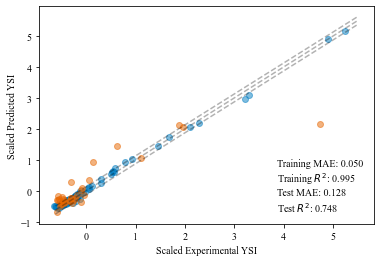

/Users/tjkessler/anaconda3/envs/ecnet/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


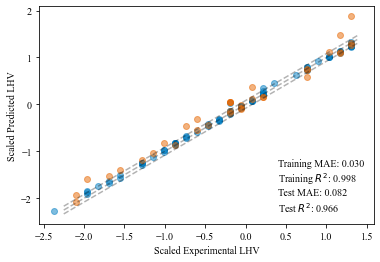

In [12]:
model_multi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_multi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_multi(ds_train.desc_vals).detach().numpy()
pred_test = model_multi(ds_test.desc_vals).detach().numpy()

pred_train_ysi = [p[0] for p in pred_train]
pred_train_lhv = [p[1] for p in pred_train]
pred_test_ysi = [p[0] for p in pred_test]
pred_test_lhv = [p[1] for p in pred_test]

mae_train_ysi = median_absolute_error(ysi_train, pred_train_ysi)
mae_train_lhv = median_absolute_error(lhv_train, pred_train_lhv)
mae_test_ysi = median_absolute_error(ysi_test, pred_test_ysi)
mae_test_lhv = median_absolute_error(lhv_test, pred_test_lhv)

r2_train_ysi = r2_score(ysi_train, pred_train_ysi)
r2_train_lhv = r2_score(lhv_train, pred_train_lhv)
r2_test_ysi = r2_score(ysi_test, pred_test_ysi)
r2_test_lhv = r2_score(lhv_test, pred_test_lhv)

min_val = min(min(pred_train_ysi), min(ysi_train)) - 0.05 * min(min(pred_train_ysi), min(ysi_train))
max_val = max(max(pred_train_ysi), max(ysi_train)) + 0.05 * max(max(pred_train_ysi), max(ysi_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental YSI')
plt.ylabel('Scaled Predicted YSI')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test_ysi, max_val + mae_test_ysi], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test_ysi, max_val - mae_test_ysi], 'k--', alpha=0.3)
plt.scatter(ysi_train, pred_train_ysi, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(ysi_test, pred_test_ysi, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train_ysi, r2_train_ysi, mae_test_ysi, r2_test_ysi
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

min_val = min(min(pred_train_lhv), min(lhv_train)) - 0.05 * min(min(pred_train_lhv), min(lhv_train))
max_val = max(max(pred_train_lhv), max(lhv_train)) + 0.05 * max(max(pred_train_lhv), max(lhv_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental LHV')
plt.ylabel('Scaled Predicted LHV')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test_lhv, max_val + mae_test_lhv], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test_lhv, max_val - mae_test_lhv], 'k--', alpha=0.3)
plt.scatter(lhv_train, pred_train_lhv, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(lhv_test, pred_test_lhv, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train_lhv, r2_train_lhv, mae_test_lhv, r2_test_lhv
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

In [13]:
###########################
### 25 trials, JUST YSI ###
###########################

ds_train = QSPRDataset(smiles_train, ysi_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train = []
maes_test = []
r2s_train = []
r2s_test = []

for _ in range(25):

    model_ysi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_ysi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_ysi(ds_train.desc_vals).detach().numpy()
    pred_test = model_ysi(ds_test.desc_vals).detach().numpy()

    maes_train.append(median_absolute_error(ysi_train, pred_train))
    maes_test.append(median_absolute_error(ysi_test, pred_test))

    r2s_train.append(r2_score(ysi_train, pred_train))
    r2s_test.append(r2_score(ysi_test, pred_test))

print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train), np.std(maes_train)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train), np.std(r2s_train)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test), np.std(maes_test)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test), np.std(r2s_test)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/2801915058.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/2801915058.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Training set MAE: 0.030 +/- 0.030
Training set R2: 0.973 +/- 0.052
Test set MAE: 0.116 +/- 0.044
Test set R2: 0.738 +/- 0.051


In [14]:
###########################
### 25 trials, JUST LHV ###
###########################

ds_train = QSPRDataset(smiles_train, lhv_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, lhv_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train = []
maes_test = []
r2s_train = []
r2s_test = []

for _ in range(25):

    model_lhv = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_lhv.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_lhv(ds_train.desc_vals).detach().numpy()
    pred_test = model_lhv(ds_test.desc_vals).detach().numpy()

    maes_train.append(median_absolute_error(lhv_train, pred_train))
    maes_test.append(median_absolute_error(lhv_test, pred_test))

    r2s_train.append(r2_score(lhv_train, pred_train))
    r2s_test.append(r2_score(lhv_test, pred_test))

print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train), np.std(maes_train)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train), np.std(r2s_train)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test), np.std(maes_test)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test), np.std(r2s_test)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/260997071.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/260997071.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Training set MAE: 0.040 +/- 0.039
Training set R2: 0.971 +/- 0.072
Test set MAE: 0.112 +/- 0.055
Test set R2: 0.939 +/- 0.061


In [15]:
##############################
### 25 trials, LHV and YSI ###
##############################

targets_train = np.concatenate((np.array(ysi_train), np.array(lhv_train)), axis=1)
targets_test = np.concatenate((np.array(ysi_test), np.array(lhv_test)), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, ysi_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train_ysi = []
maes_train_lhv = []
maes_test_ysi = []
maes_test_lhv = []
r2s_train_ysi = []
r2s_train_lhv = []
r2s_test_ysi = []
r2s_test_lhv = []

for _ in range(25):

    model_multi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_multi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_multi(ds_train.desc_vals).detach().numpy()
    pred_test = model_multi(ds_test.desc_vals).detach().numpy()
    pred_train_ysi = [p[0] for p in pred_train]
    pred_train_lhv = [p[1] for p in pred_train]
    pred_test_ysi = [p[0] for p in pred_test]
    pred_test_lhv = [p[1] for p in pred_test]

    maes_train_ysi.append(median_absolute_error(ysi_train, pred_train_ysi))
    maes_train_lhv.append(median_absolute_error(lhv_train, pred_train_lhv))
    maes_test_ysi.append(median_absolute_error(ysi_test, pred_test_ysi))
    maes_test_lhv.append(median_absolute_error(lhv_test, pred_test_lhv))

    r2s_train_ysi.append(r2_score(ysi_train, pred_train_ysi))
    r2s_train_lhv.append(r2_score(lhv_train, pred_train_lhv))
    r2s_test_ysi.append(r2_score(ysi_test, pred_test_ysi))
    r2s_test_lhv.append(r2_score(lhv_test, pred_test_lhv))

print('YSI:')
print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train_ysi), np.std(maes_train_ysi)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train_ysi), np.std(r2s_train_ysi)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test_ysi), np.std(maes_test_ysi)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test_ysi), np.std(r2s_test_ysi)))
print('\nLHV:')
print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train_lhv), np.std(maes_train_lhv)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train_lhv), np.std(r2s_train_lhv)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test_lhv), np.std(maes_test_lhv)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test_lhv), np.std(r2s_test_lhv)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/788557582.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_53999/788557582.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


YSI:
Training set MAE: 0.025 +/- 0.024
Training set R2: 0.995 +/- 0.009
Test set MAE: 0.100 +/- 0.020
Test set R2: 0.778 +/- 0.031

LHV:
Training set MAE: 0.026 +/- 0.021
Training set R2: 0.995 +/- 0.006
Test set MAE: 0.093 +/- 0.026
Test set R2: 0.964 +/- 0.013
